# The blink issue
The stripes seen in the time-frequency representation are suspected to come from the blink. 
First to confirm visually this hypothesis I am going to overlay the time-frequency and the time-series for individual channels:
 - The 2 frontal channels on which it is known to exhibit the most the blink components.
 - Cz that is farther from the frontal lobe and should exhibit less blinks (therefore, hypothetically less stripes on the Time-Frequency representation)

Extracting EDF parameters from /projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF/sub-01_ses-01_task-checker_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 60499  =      0.000 ...   241.996 secs...


/tmp/ipykernel_21949/2512773346.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
/tmp/ipykernel_21949/2512773346.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
/tmp/ipykernel_21949/2512773346.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])


from 3 to 10
from 3 to 10
from 3 to 10


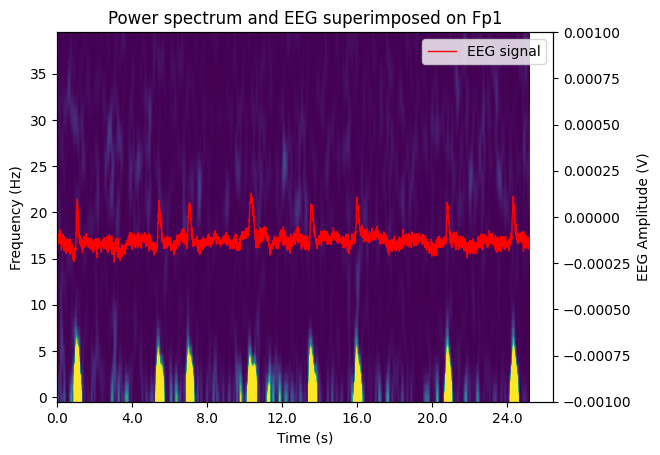

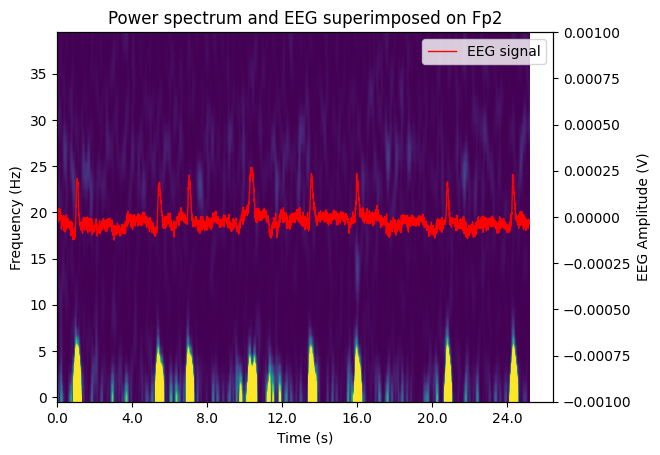

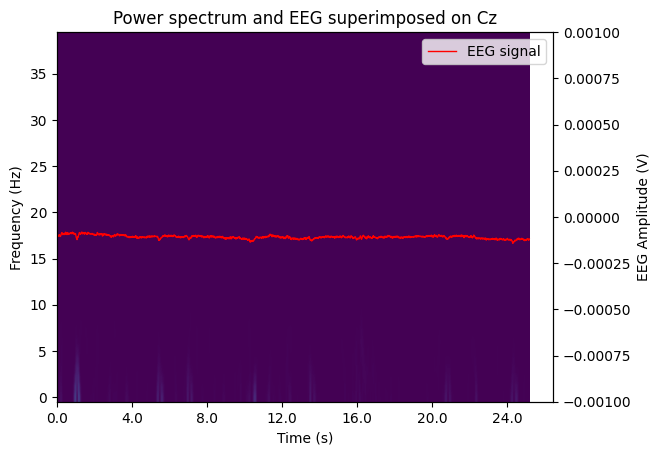

In [1]:
import mne
from pathlib import Path
import eeg_fmri_cleaning.utils as utils
import numpy as np
import pickle
import matplotlib.pyplot as plt
subject = '01'
derivatives_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/DERIVATIVES/eeg_features_extraction')
raw_path = Path('/projects/EEG_FMRI/bids_eeg/BIDS/NEW/PREP_BV_EDF')
filename = f'sub-{subject}_ses-01_task-checker_run-01_eeg.edf'
raw = mne.io.read_raw_edf(raw_path / filename, preload=True)
envelope_path = derivatives_path / f'sub-{subject}/ses-01/eeg/sub-{subject}_ses-01_task-checker_run-01_desc-MorletTFR_eeg.pkl'
with open (envelope_path, 'rb') as file:
    envelope = pickle.load(file)
array = raw.get_data()
onsets = raw.annotations.onset[np.where(raw.annotations.description == 'R128')]
ch_names = ['Fp1', 'Fp2', 'Cz']
start = 3
stop = 10
start_array = int(onsets[3] * raw.info['sfreq'])
stop_array = int(onsets[15] * raw.info['sfreq'])
start_envelope = int((onsets[3] - onsets[0]) * raw.info['sfreq'])
stop_envelope = int((onsets[15] - onsets[0]) * raw.info['sfreq'])

for channel in ch_names:
    plt.figure()
    channel_index = envelope['channels_info']['channel_name'].index(channel)
    plt.imshow(envelope['feature'][channel_index,:,start_envelope:stop_envelope], 
            aspect = 'auto', 
            origin = 'lower',
            vmin = 0,
            vmax = 1e-7
            )
    plt.gca().set_ylabel('Frequency (Hz)')
    plt.title(f'Power spectrum and EEG superimposed on {channel}')
    plt.xlabel('Time (s)')
    ax2 = plt.gca().twinx()
    ax2.set_ylim(-1e-3, 1e-3)
    ax2.plot(array[channel_index,start_array:stop_array], color = 'red', linewidth = 1, label = 'EEG signal')
    plt.legend()
    plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
    print(f"from {start} to {stop}")
    ax2.set_ylabel('EEG Amplitude (V)')



As we can see the stripes corresponds to the blinks (we can even see on Cz the inversion of polarity but still at the time of the blinks seen on Fp1 and Fp2).
Now the artifact is identified let's remove it through SSP projectors.
Let's do an automated detection of blinks based on Fp1 and Fp2 channels. This choice have been made because these 2 channels are less polluted by the ballistocardiographic artifacts than the traditional EOGU and EOGL channels. Let's check if the detection is correct by first plotting the average time-course of blinks after epoching around detected blinks.

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Not setting metadata
106 matching events found


No baseline correction applied
Using data from preloaded Raw for 106 events and 251 original time points ...
0 bad epochs dropped
Applying baseline correction (mode: mean)
No projector specified for this dataset. Please consider the method self.add_proj.


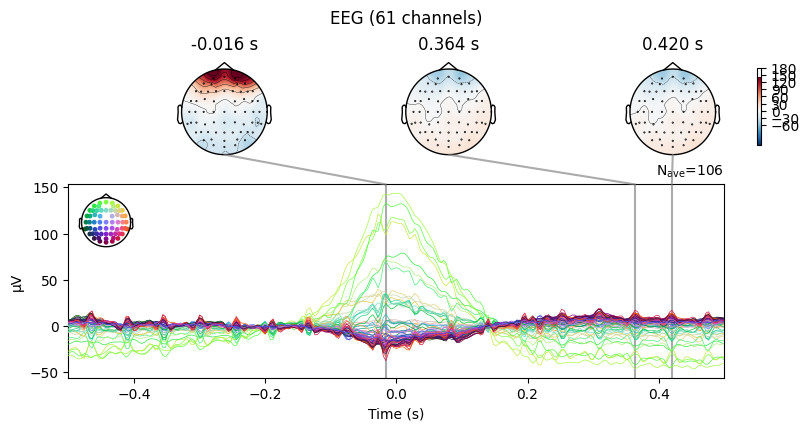

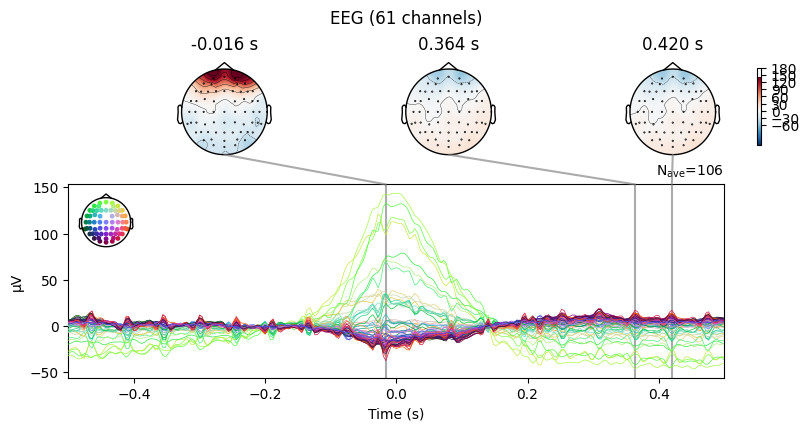

In [2]:
map = utils.map_channel_type(raw)
raw.set_channel_types(map)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage)
eog_evoked = mne.preprocessing.create_eog_epochs(raw, ch_name = ['Fp1','Fp2']).average()
eog_evoked.apply_baseline((None, None))
eog_evoked.plot_joint()

The spatiotemporal pattern is typical to blinks: high amplitude and low frequency.
Let's remove them now.
Also one will note the presence of the residual gradient artifacts.

Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Not setting metadata
106 matching events found
No baseline correction applied
Using data from preloaded Raw for 106 events and 251 original time points ...
0 bad epochs dropped
Applying baseline corr

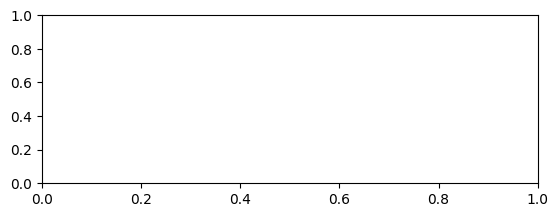

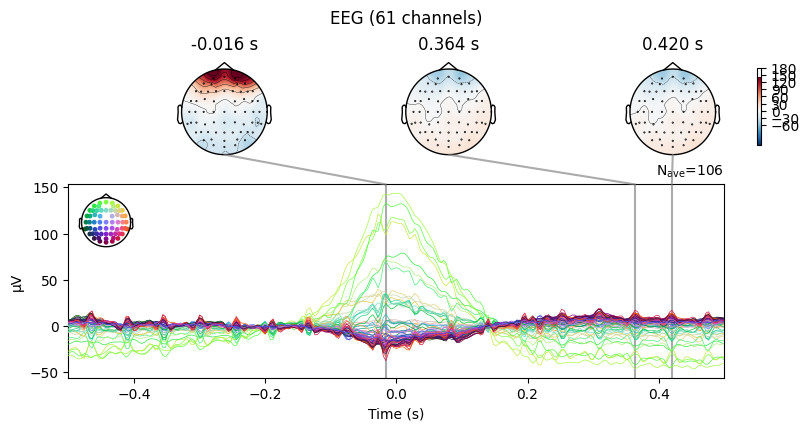

Running EOG SSP computation
Using EOG channels: Fp1, Fp2
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel Fp1 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 106 significant peaks
Number of EOG events detected: 106
Computing projector
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


TypeError: plot_projs_joint() got an unexpected keyword argument 'axes'

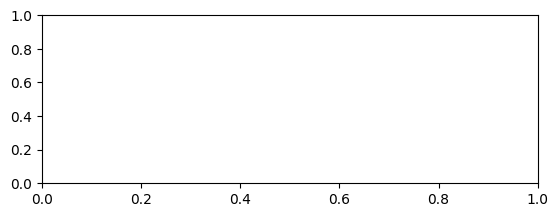

In [9]:
map = utils.map_channel_type(raw)
raw.set_channel_types(map)
montage = mne.channels.make_standard_montage('easycap-M1')
raw.set_montage(montage)
eog_evoked = mne.preprocessing.create_eog_epochs(raw, ch_name = ['Fp1','Fp2']).average()
eog_evoked.apply_baseline((None, None))
fig = plt.figure()

eog_evoked.plot()
eog_projs, _ = mne.preprocessing.compute_proj_eog(
    raw, n_eeg=1, reject=None, no_proj=True, ch_name=['Fp1','Fp2']
)
axes = plt.subplot(2,1,2)
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked,
                               axes = axes)
fig.suptitle("EOG projectors")

The projection worked well. Let's see on raw data with the same time window as the plot overlayed with the Time Frequency

1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


/tmp/ipykernel_2275668/3063790465.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
/tmp/ipykernel_2275668/3063790465.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
/tmp/ipykernel_2275668/3063790465.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])


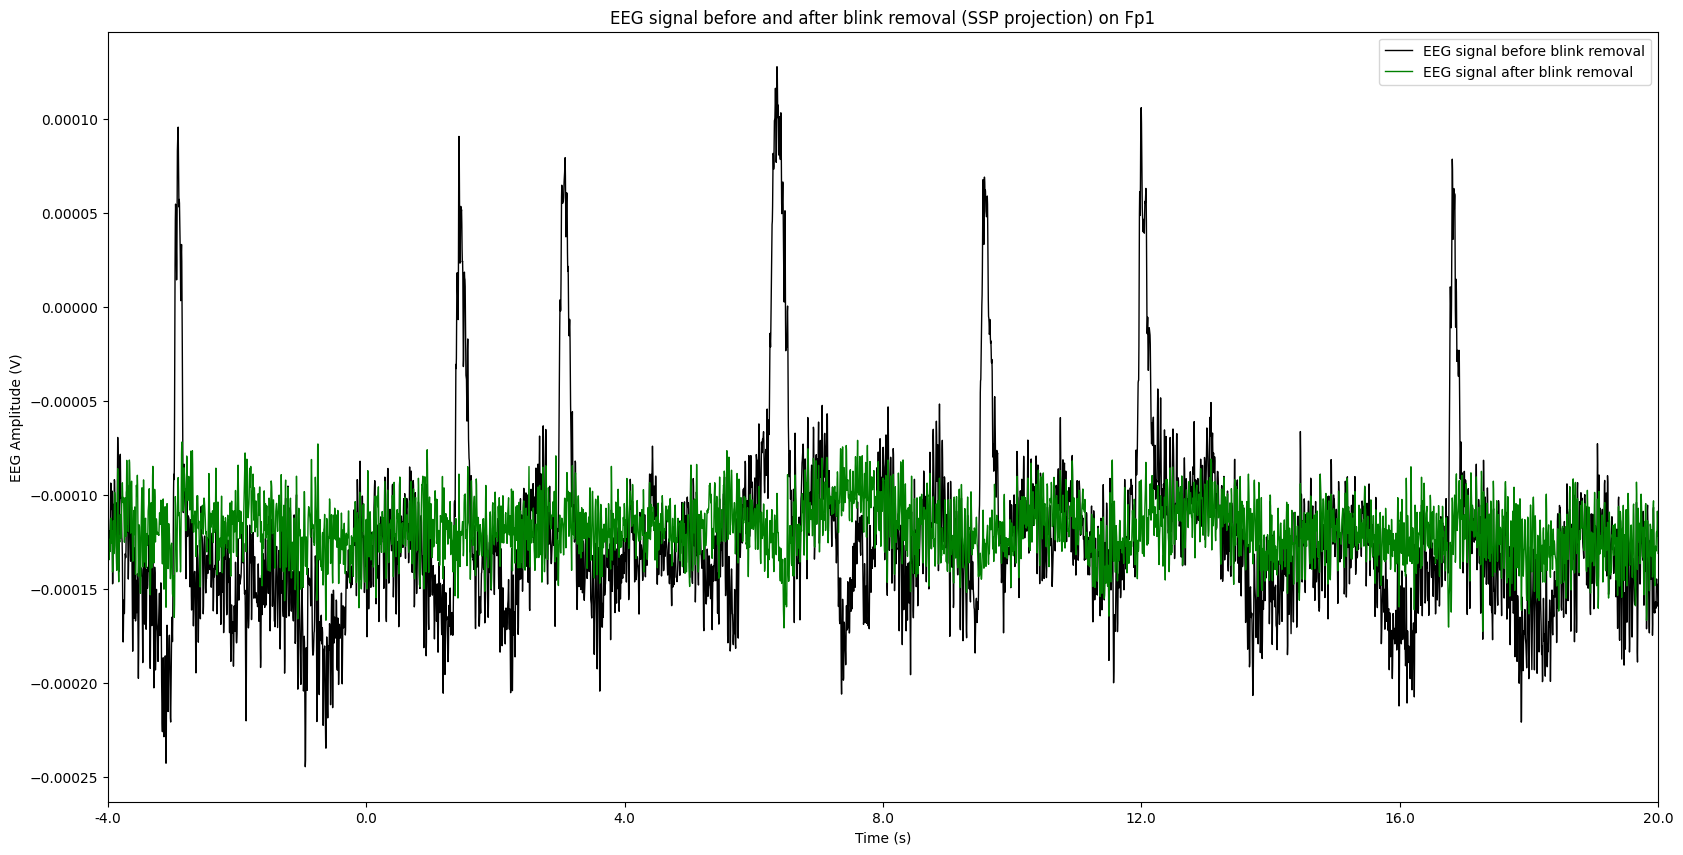

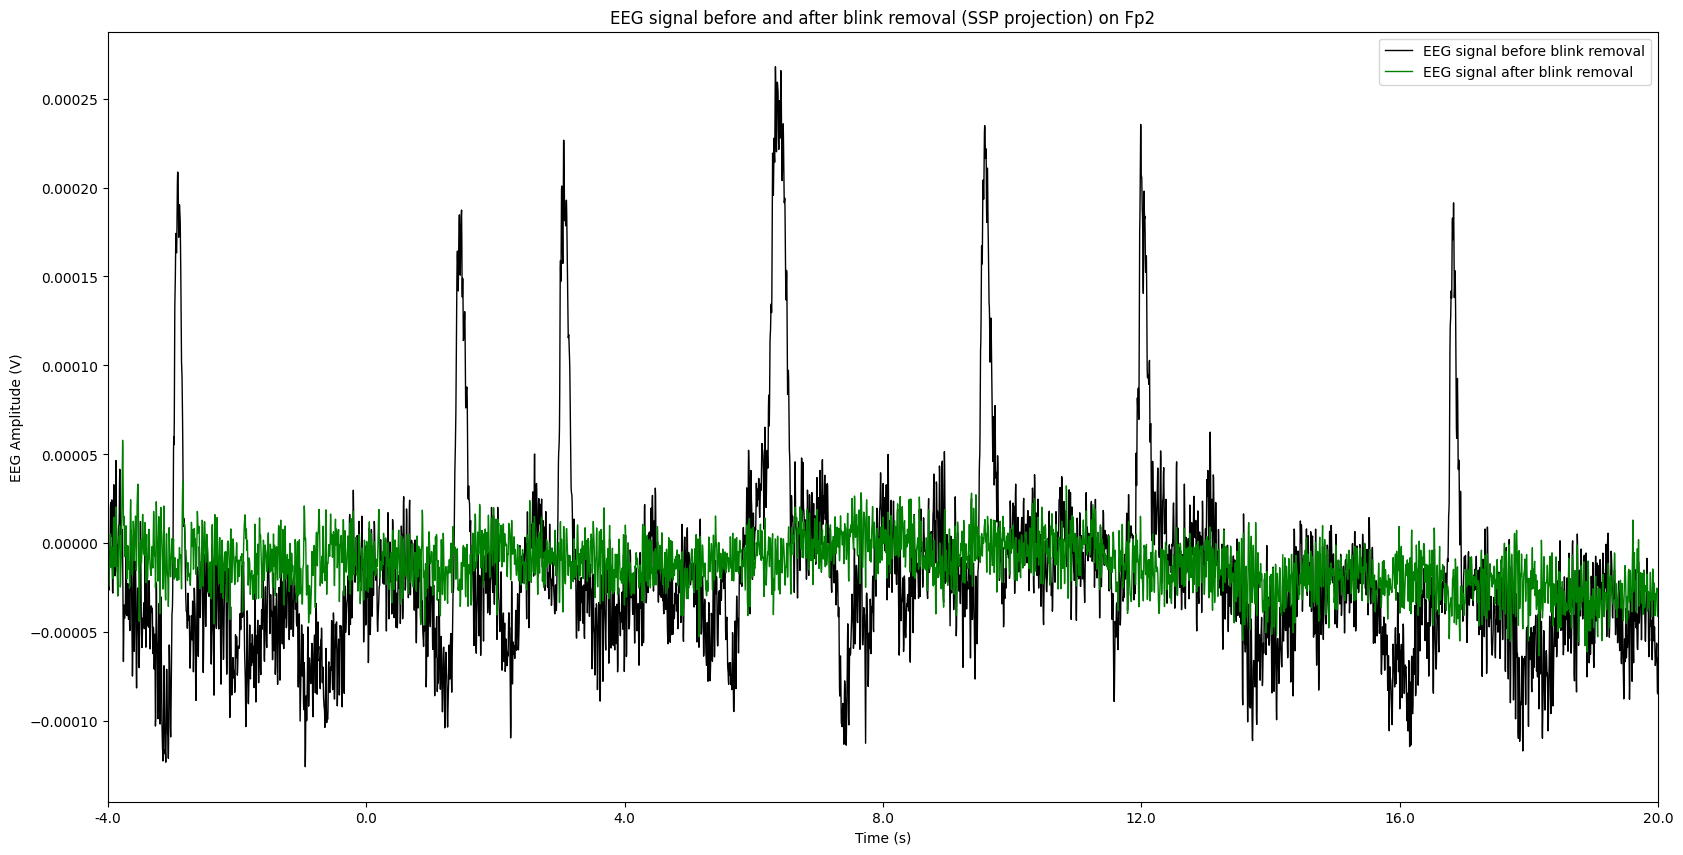

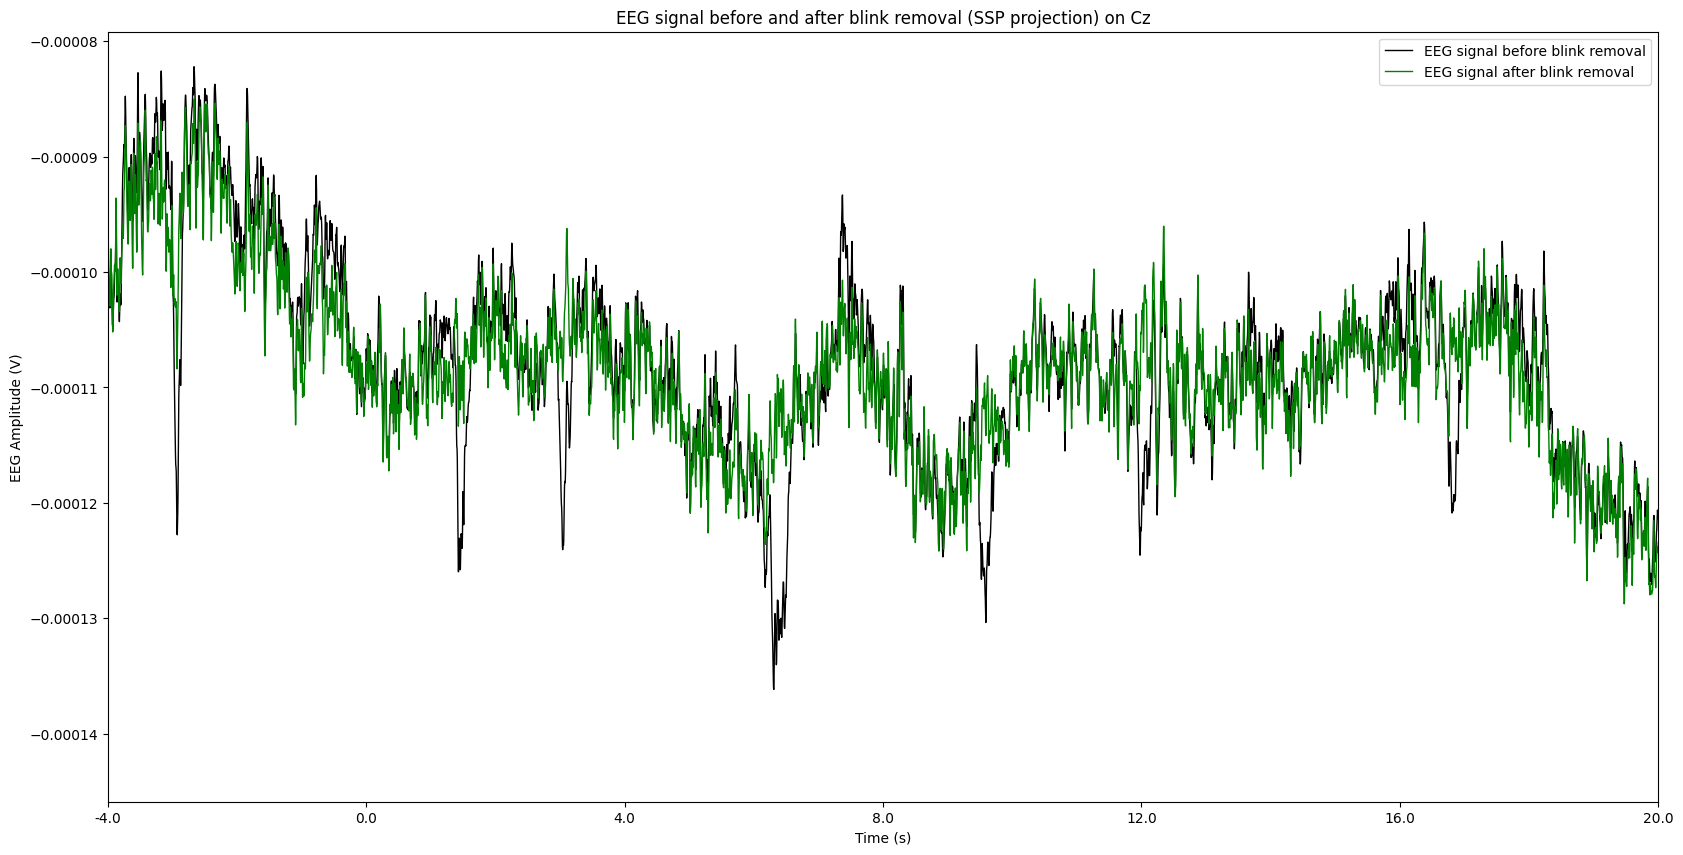

In [5]:
array_after = raw.add_proj(eog_projs).apply_proj().get_data()
for channel in ch_names:
    channel_index = envelope['channels_info']['channel_name'].index(channel)
    plt.figure(figsize = (20,10))
    plt.plot(array[channel_index,start_array:stop_array], color = 'black', linewidth = 1, label = 'EEG signal before blink removal')
    plt.plot(array_after[channel_index,start_array:stop_array], color = 'green', linewidth = 1, label = 'EEG signal after blink removal')
    plt.legend()
    plt.gca().set_xticklabels(plt.gca().get_xticks() / raw.info['sfreq'])
    plt.gca().set_ylabel('EEG Amplitude (V)')
    plt.gca().set_xlabel('Time (s)')
    plt.xlim(0, 6000)
    plt.title(f'EEG signal before and after blink removal (SSP projection) on {channel}')